### Part 1: Imports and Setup
Run this cell to import necessary libraries and configure plotting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
import joblib
import json

# Ensure plots display inline in the notebook
%matplotlib inline 

# Set plot style for better aesthetics
sns.set(style="whitegrid")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Ensure plots display inline
%matplotlib inline

### Part 2: Load the Dataset
Load the raw CSV file and display the initial shape and structure.

In [2]:
# Read the CSV file
# Note: The original dataset uses semi-colons as delimiters and commas for decimals
df = pd.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', encoding='utf-8')

# Display original info
print("Original Data Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"First few rows:")
display(df.head()) 

Original Data Info:
Shape: (9471, 17)
Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']
First few rows:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


### Part 3: Basic Cleaning (Missing Values & Columns)
Handle standard missing value indicators (-200), remove empty columns, and clean up column names.

In [3]:
# 1. Handle missing values (replace -200 and -200,0 with NaN)
df.replace({'-200': np.nan, '-200,0': np.nan, -200: np.nan}, inplace=True)

# 2. Fix the last column (remove trailing semicolon issue)
if ';' in df.columns[-1]:
    df = df.drop(df.columns[-1], axis=1)

# 3. Clean column names (strip whitespace)
df.columns = [col.strip() for col in df.columns]

print(f"Columns after cleaning: {list(df.columns)}")

Columns after cleaning: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']


### Part 4: Data Formatting & Type Conversion
Fix time formats, handle decimal separators (commas to dots), and convert columns to numeric types.

In [4]:
# 4. Fix time format (convert HH.MM.SS to HH:MM)
df['Time'] = df['Time'].astype(str).str.replace('.', ':', regex=False)
df['Time'] = df['Time'].str[:5] # Remove seconds if present

# 5. Fix decimal separators and clean numeric columns
# Iterate through columns to replace commas with dots and handle trailing semicolons
for col in df.columns:
    if df[col].dtype == 'object':
        # Remove any trailing semicolons
        df[col] = df[col].astype(str).str.replace(';', '', regex=False)
        # Replace commas with dots for decimal numbers
        df[col] = df[col].str.replace(',', '.', regex=False)
        
# 6. Create a combined datetime column for time series analysis
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M', errors='coerce')

# 7. Set proper data types (Convert specific columns to float)
numeric_cols = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 
                'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 
                'PT08.S5(O3)', 'T', 'RH', 'AH']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Data types updated.")
df.dtypes

Data types updated.


Date                     object
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
Unnamed: 15             float64
Unnamed: 16             float64
DateTime         datetime64[ns]
dtype: object

### Part 5: Filtering and Sorting
Remove rows that are mostly empty and sort the data chronologically.

In [5]:

df_clean = df.copy()

# 1. Drop useless columns
cols_to_drop = ['Unnamed: 15', 'Unnamed: 16', 'NMHC(GT)']
df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns], inplace=True)
print(f"Dropped columns: {[c for c in cols_to_drop if c in df.columns]}")

# 2. Interpolate numeric columns (time-series friendly)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].interpolate(
    method='linear',
    limit_direction='both'
)

print("\nPost-Fix Missing Values:")
print(df_clean.isnull().sum())

# 3. Remove rows with excessive missing values (>50%)
missing_per_row = df_clean.isnull().sum(axis=1) / len(df_clean.columns) * 100
df_clean = df_clean[missing_per_row <= 50].copy()

# 4. Sort by DateTime and reset index
df_clean.sort_values('DateTime', inplace=True)
df_clean.reset_index(drop=True, inplace=True)

print(f"Rows before filtering: {len(df)}")
print(f"Rows after filtering: {len(df_clean)}")

# 5. Export cleaned data
df_clean.to_csv('AirQualityUCI_cleaned_v2.csv', index=False)
print("Real cleaning complete. Ghost columns removed and gaps filled.")


Dropped columns: ['Unnamed: 15', 'Unnamed: 16', 'NMHC(GT)']

Post-Fix Missing Values:
Date               0
Time               0
CO(GT)             0
PT08.S1(CO)        0
C6H6(GT)           0
PT08.S2(NMHC)      0
NOx(GT)            0
PT08.S3(NOx)       0
NO2(GT)            0
PT08.S4(NO2)       0
PT08.S5(O3)        0
T                  0
RH                 0
AH                 0
DateTime         114
dtype: int64
Rows before filtering: 9471
Rows after filtering: 9471
Real cleaning complete. Ghost columns removed and gaps filled.


### Part 6: Statistical Summary
Check the health of the cleaned dataset.

In [6]:
# 10. Summary statistics
print("Cleaned Data Info:")
print(f"Shape: {df_clean.shape}")

# Calculate missing stats
missing_values = df_clean.isnull().sum()
print(f"\nMissing Values per Column:\n{missing_values[missing_values > 0]}")

print(f"\nStatistical Summary:")
display(df_clean.describe())

Cleaned Data Info:
Shape: (9471, 15)

Missing Values per Column:
DateTime    114
dtype: int64

Statistical Summary:


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
count,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.00000,9471.000000,9471.000000,9471.000000,9357
mean,2.131438,1102.673846,10.199868,943.404762,242.199979,830.607222,110.334653,1449.395312,1029.93781,18.356984,48.756963,1.013400,2004-09-21 16:00:00
min,0.100000,647.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.00000,-1.900000,9.200000,0.184700,2004-03-10 18:00:00
25%,1.100000,939.000000,4.500000,739.000000,96.057823,654.000000,76.000000,1215.000000,737.00000,11.800000,35.300000,0.719400,2004-06-16 05:00:00
50%,1.800000,1071.000000,8.400000,914.000000,181.727273,800.000000,105.000000,1455.000000,964.00000,17.700000,49.400000,0.984600,2004-09-21 16:00:00
75%,2.900000,1236.000000,14.000000,1117.000000,323.000000,965.000000,138.000000,1664.000000,1288.50000,24.500000,62.100000,1.301900,2004-12-28 03:00:00
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.00000,44.600000,88.700000,2.231000,2005-04-04 14:00:00
std,1.423113,216.907224,7.460870,266.494895,203.097172,254.912582,46.618419,342.962507,402.69890,8.800287,17.538067,0.403728,NaN


### Part 7: Visualization - Missing Data Heatmap
Visualize where gaps still exist in the data.

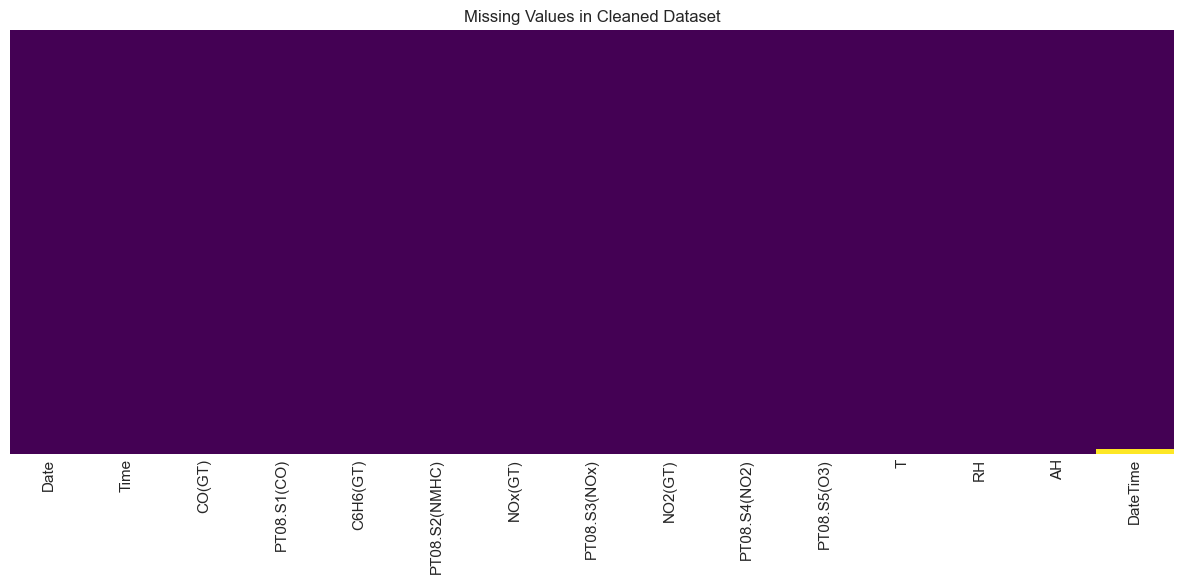

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values in Cleaned Dataset')
plt.tight_layout()
plt.show()

### Part 8: Visualization - Time Series
Plot the concentration of CO(GT) over time.

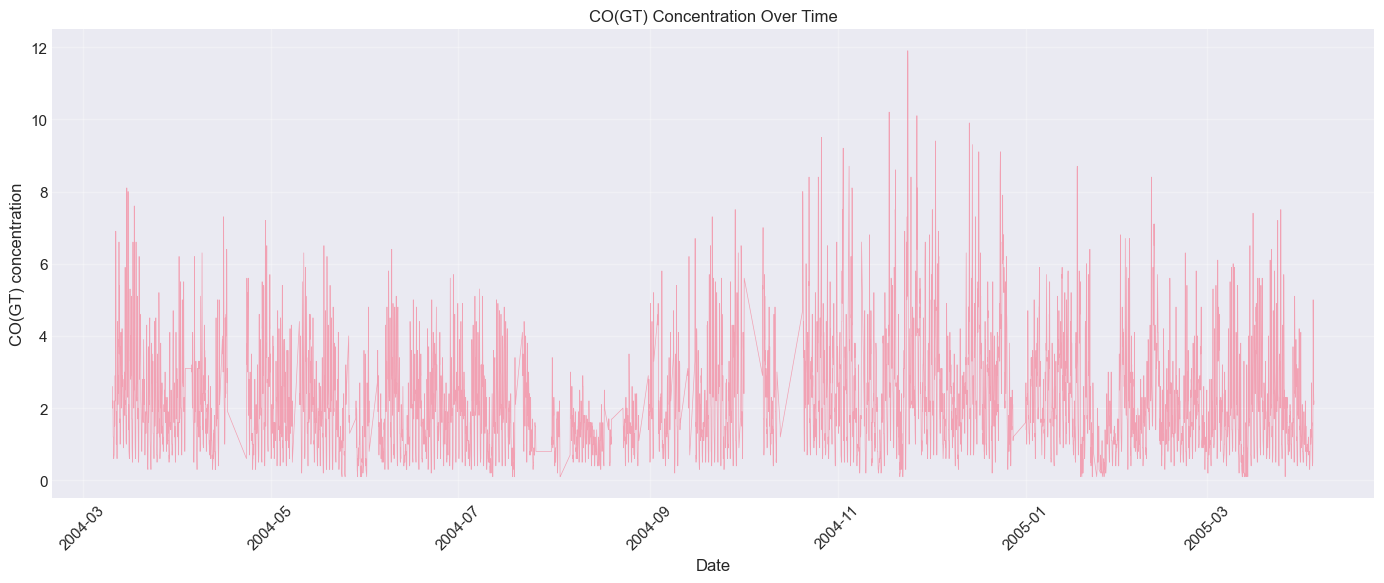

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df_clean['DateTime'], df_clean['CO(GT)'], alpha=0.6, linewidth=0.5)
plt.title('CO(GT) Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('CO(GT) concentration')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Part 9: Visualization - Correlation Matrix
Analyze relationships between different air quality variables.

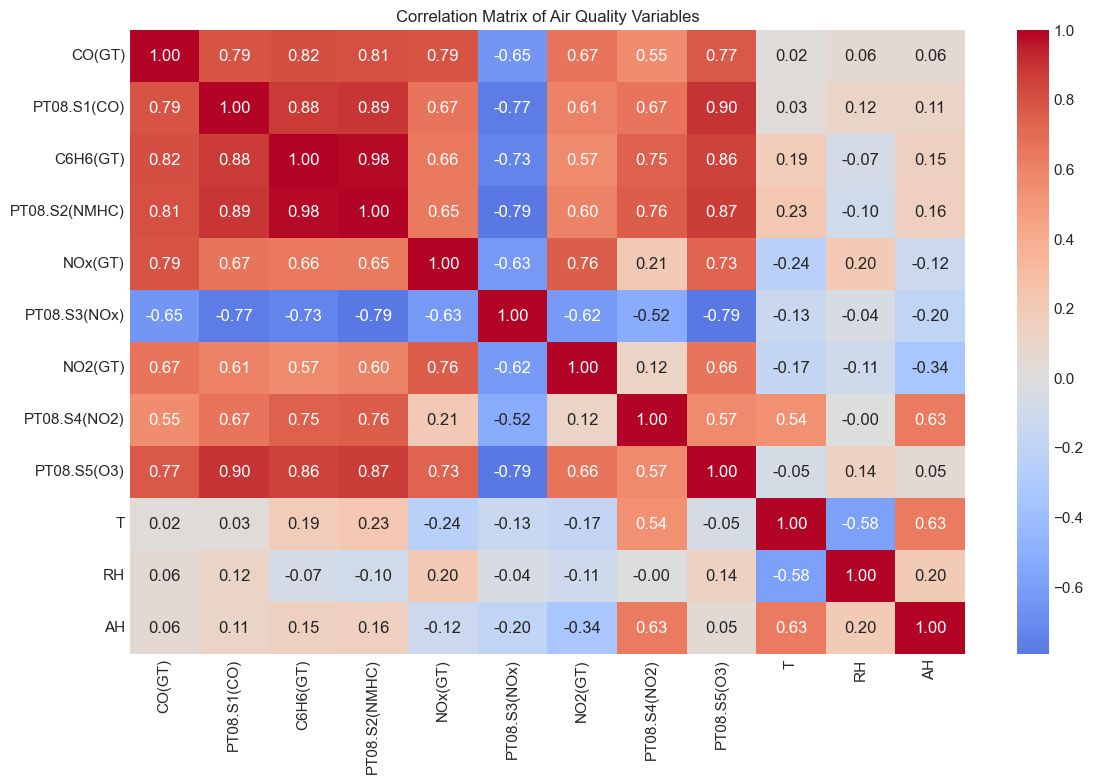

In [9]:
## Select only numeric columns for correlation
numeric_df = df_clean.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Air Quality Variables')
plt.tight_layout()
# plt.savefig('correlation_matrix.png') # Uncomment to save
plt.show()

### Part 10: Export Cleaned Data
Save the final dataset to a new CSV file.

In [10]:
# 11. Save cleaned data
output_filename = 'AirQualityUCI_cleaned.csv'
df_clean.to_csv(output_filename, index=False)

print("="*80)
print("DATA CLEANING COMPLETE!")
print(f"Cleaned data saved to '{output_filename}'")
print(f"Original dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Cleaned dataset: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.1f}%)")

DATA CLEANING COMPLETE!
Cleaned data saved to 'AirQualityUCI_cleaned.csv'
Original dataset: 9471 rows, 18 columns
Cleaned dataset: 9471 rows, 15 columns
Rows removed: 0 (0.0%)


### 11.1 Load Data for Analysis
Load the cleaned dataset. If the file is missing, we will generate sample data for demonstration purposes.

In [11]:
# Function to load and parse data
def load_and_parse_data(file_path):
    """
    Load the cleaned air quality dataset
    """
    try:
        # Read the CSV (assuming it was saved with standard comma delimiter in Part 10)
        df = pd.read_csv(file_path)
        
        # Convert DateTime column back to datetime objects
        if 'DateTime' in df.columns:
            df['DateTime'] = pd.to_datetime(df['DateTime'])
            
        return df, True
    except FileNotFoundError:
        return None, False

# Attempt to load the file
file_path = 'AirQualityUCI_cleaned_v2.csv' 
df, success = load_and_parse_data(file_path)

if success:
    print("✓ Data loaded successfully!")
    print(f"Data shape: {df.shape}")
else:
    # Create sample data for demonstration if file not found
    print("⚠ File not found. Creating sample data for demonstration...")
    np.random.seed(42)
    date_range = pd.date_range(start='2004-03-10', end='2005-04-04', freq='H')
    n_samples = len(date_range)
    
    # Create sample data similar to the dataset description
    data = {
        'CO(GT)': np.random.uniform(1.0, 10.0, n_samples),
        'PT08.S1(CO)': np.random.uniform(1000, 2000, n_samples),
        'NMHC(GT)': np.random.uniform(50, 200, n_samples),
        'C6H6(GT)': np.random.uniform(5, 20, n_samples),
        'PT08.S2(NMHC)': np.random.uniform(800, 1200, n_samples),
        'NOx(GT)': np.random.uniform(100, 500, n_samples),
        'PT08.S3(NOx)': np.random.uniform(500, 1200, n_samples),
        'NO2(GT)': np.random.uniform(50, 200, n_samples),
        'PT08.S4(NO2)': np.random.uniform(1000, 1800, n_samples),
        'PT08.S5(O3)': np.random.uniform(700, 1800, n_samples),
        'T': np.random.uniform(10, 30, n_samples),
        'RH': np.random.uniform(20, 80, n_samples),
        'AH': np.random.uniform(0.5, 1.2, n_samples),
        'DateTime': date_range
    }
    df = pd.DataFrame(data)
    print("✓ Sample data created for demonstration")

# Set DateTime as index for time-series analysis
if 'DateTime' in df.columns:
    df = df.set_index('DateTime').sort_index()

# Display basic info
print("\n" + "="*60)
print("DATASET INFORMATION")
print("="*60)
display(df.head())
print(f"\nDate range: {df.index.min()} to {df.index.max()}")

✓ Data loaded successfully!
Data shape: (9471, 15)

DATASET INFORMATION


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,10/03/2004,19:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,10/03/2004,20:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,10/03/2004,21:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,10/03/2004,22:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888



Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00


### 11.2 Correlation Analysis
Analyze how sensor readings correlate with ground truth pollutant concentrations.


1. CORRELATION ANALYSIS
Ground truth columns: ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
Sensor columns: ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']


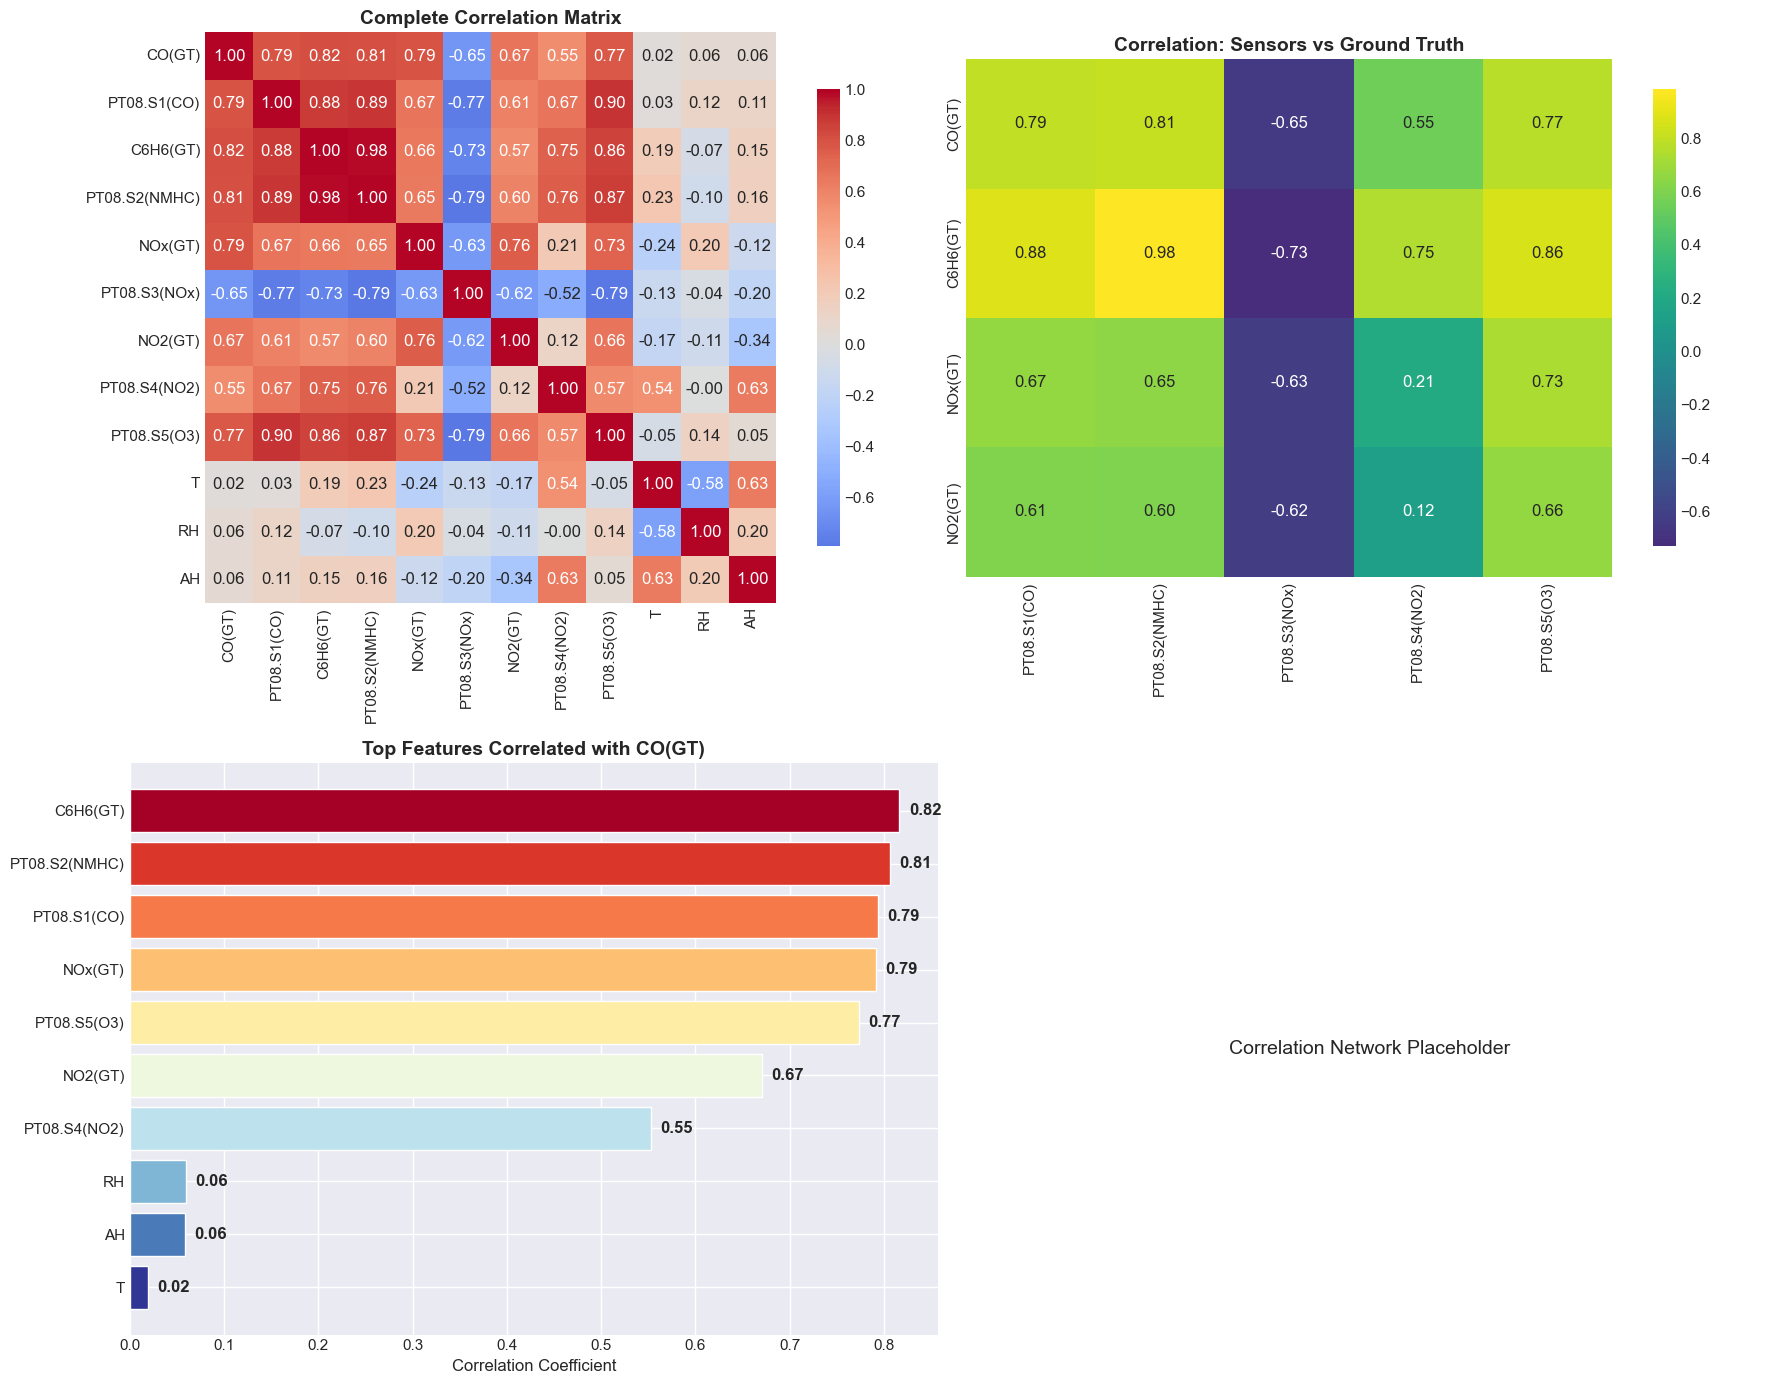


Top positive correlations with CO(GT):
CO(GT)           1.000000
C6H6(GT)         0.816382
PT08.S2(NMHC)    0.806568
PT08.S1(CO)      0.793854
NOx(GT)          0.791266
PT08.S5(O3)      0.773161
Name: CO(GT), dtype: float64


In [12]:
print("\n" + "="*60)
print("1. CORRELATION ANALYSIS")
print("="*60)

# Identify columns
gt_columns = [col for col in df.columns if '(GT)' in col and 'PT08' not in col]
sensor_columns = [col for col in df.columns if 'PT08' in col]

print(f"Ground truth columns: {gt_columns}")
print(f"Sensor columns: {sensor_columns}")

# Calculate correlation matrix
# Filter to ensure we only use numeric columns present in the dataframe
valid_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
correlation_matrix = df[valid_cols].corr()

# Separate correlations between sensors and ground truth
gt_sensor_corr = correlation_matrix.loc[[c for c in gt_columns if c in correlation_matrix.index], 
                                      [c for c in sensor_columns if c in correlation_matrix.columns]]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Complete correlation heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=axes[0, 0], cbar_kws={'shrink': 0.8})
axes[0, 0].set_title('Complete Correlation Matrix', fontsize=14, fontweight='bold')

# Plot 2: Correlation between sensors and ground truth
if not gt_sensor_corr.empty:
    sns.heatmap(gt_sensor_corr, annot=True, fmt='.2f', cmap='viridis', 
                center=0, square=True, ax=axes[0, 1], cbar_kws={'shrink': 0.8})
    axes[0, 1].set_title('Correlation: Sensors vs Ground Truth', fontsize=14, fontweight='bold')

# Plot 3: Top correlations with CO(GT)
if 'CO(GT)' in df.columns:
    co_correlations = correlation_matrix['CO(GT)'].drop('CO(GT)').sort_values(ascending=False)
    top_corr = co_correlations.head(10)
    
    ax = axes[1, 0]
    colors = plt.cm.RdYlBu(np.linspace(0, 1, len(top_corr)))
    bars = ax.barh(range(len(top_corr)), top_corr.values, color=colors)
    ax.set_yticks(range(len(top_corr)))
    ax.set_yticklabels(top_corr.index)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_title('Top Features Correlated with CO(GT)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(top_corr.values):
        ax.text(v + (0.01 if v >= 0 else -0.05), i, f'{v:.2f}', 
                va='center', fontweight='bold')

# Plot 4: Empty / Placeholder or Network
axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.5, 'Correlation Network Placeholder', 
                ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

# Print Insights
if 'CO(GT)' in correlation_matrix.columns:
    print("\nTop positive correlations with CO(GT):")
    print(correlation_matrix['CO(GT)'].sort_values(ascending=False).head(6))

### 11.3 Time-Series Visualization
Focus on a specific month to visualize daily and weekly pollutant trends


2. TIME-SERIES ANALYSIS
Analyzing period: 2004-03-10 18:00:00 to 2004-03-31 23:00:00


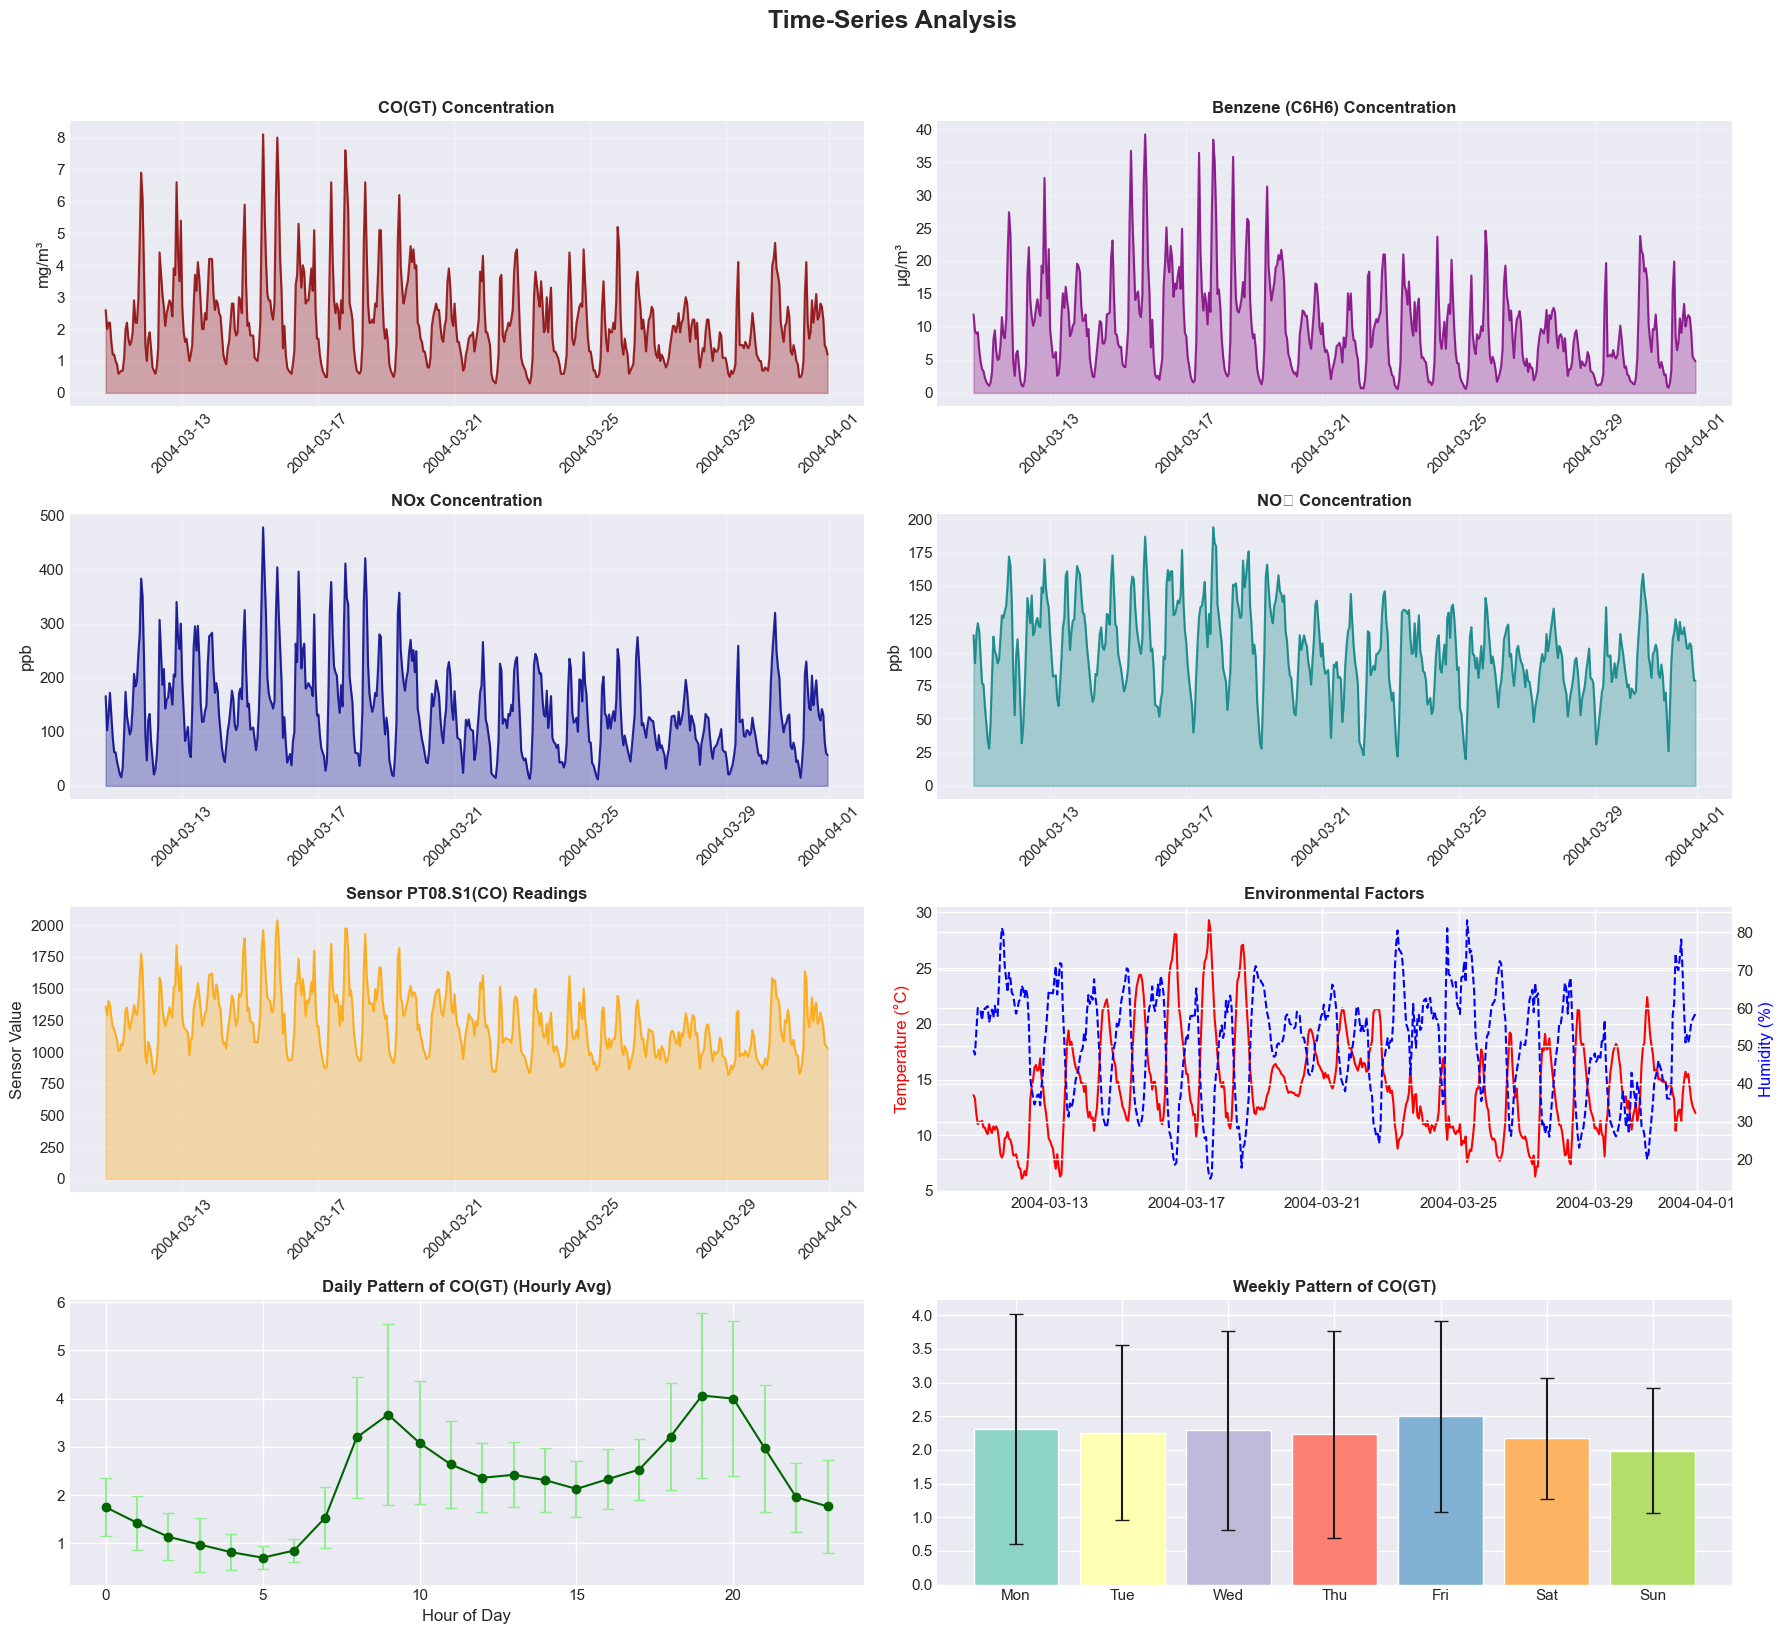

In [13]:
print("\n" + "="*60)
print("2. TIME-SERIES ANALYSIS")
print("="*60)

# Select a month for detailed analysis
selected_month = '2004-03' # Adjust based on data availability
if selected_month in df.index.strftime('%Y-%m').unique():
    month_data = df[df.index.strftime('%Y-%m') == selected_month].copy()
else:
    month_data = df.iloc[:720].copy() # Default to first ~30 days if specific month missing

print(f"Analyzing period: {month_data.index.min()} to {month_data.index.max()}")

# Create time-series plots
fig, axes = plt.subplots(4, 2, figsize=(18, 16))
fig.suptitle(f'Time-Series Analysis', fontsize=18, fontweight='bold', y=1.02)

# Helper function for plotting
def plot_ts(ax, data, col, color, title, ylabel):
    if col in data.columns:
        ax.plot(data.index, data[col], color=color, linewidth=1.5, alpha=0.8)
        ax.fill_between(data.index, 0, data[col], alpha=0.3, color=color)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

# Plot Pollutants
plot_ts(axes[0, 0], month_data, 'CO(GT)', 'darkred', 'CO(GT) Concentration', 'mg/m³')
plot_ts(axes[0, 1], month_data, 'C6H6(GT)', 'purple', 'Benzene (C6H6) Concentration', 'µg/m³')
plot_ts(axes[1, 0], month_data, 'NOx(GT)', 'darkblue', 'NOx Concentration', 'ppb')
plot_ts(axes[1, 1], month_data, 'NO2(GT)', 'teal', 'NO₂ Concentration', 'ppb')

# Plot Sensor Data
plot_ts(axes[2, 0], month_data, 'PT08.S1(CO)', 'orange', 'Sensor PT08.S1(CO) Readings', 'Sensor Value')

# Plot Environmental Factors (Dual Axis)
if all(col in month_data.columns for col in ['T', 'RH']):
    ax_temp = axes[2, 1]
    ax_temp.plot(month_data.index, month_data['T'], color='red', label='Temperature')
    ax_temp.set_ylabel('Temperature (°C)', color='red')
    
    ax_rh = ax_temp.twinx()
    ax_rh.plot(month_data.index, month_data['RH'], color='blue', linestyle='--', label='Humidity')
    ax_rh.set_ylabel('Humidity (%)', color='blue')
    ax_temp.set_title('Environmental Factors', fontsize=12, fontweight='bold')

# Plot Daily Patterns (Hourly Average)
if 'CO(GT)' in month_data.columns:
    daily_pattern = month_data.groupby(month_data.index.hour)['CO(GT)'].agg(['mean', 'std'])
    axes[3, 0].errorbar(daily_pattern.index, daily_pattern['mean'], yerr=daily_pattern['std'], 
                        fmt='o-', color='darkgreen', ecolor='lightgreen', capsize=4)
    axes[3, 0].set_title('Daily Pattern of CO(GT) (Hourly Avg)', fontsize=12, fontweight='bold')
    axes[3, 0].set_xlabel('Hour of Day')

# Plot Weekly Patterns
if 'CO(GT)' in month_data.columns:
    month_data['Weekday'] = month_data.index.weekday
    weekly_pattern = month_data.groupby('Weekday')['CO(GT)'].agg(['mean', 'std'])
    weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    axes[3, 1].bar(weekly_pattern.index, weekly_pattern['mean'], yerr=weekly_pattern['std'], 
                   color=plt.cm.Set3(range(7)), capsize=5)
    axes[3, 1].set_title('Weekly Pattern of CO(GT)', fontsize=12, fontweight='bold')
    axes[3, 1].set_xticklabels([''] + weekdays) # Fix alignment depending on matplotlib version

plt.tight_layout()
plt.show()

### 11.4 Statistical Summary
Generate a final summary table of the key variables.

In [14]:
# Create summary statistics table
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Select relevant columns
cols_to_summarize = gt_columns + ['T', 'RH', 'AH']
valid_cols = [c for c in cols_to_summarize if c in df.columns]

summary_stats = df[valid_cols].describe().T[['mean', 'std', 'min', 'max', 'count']]
display(summary_stats)


SUMMARY STATISTICS


,mean,std,min,max,count
CO(GT),2.131438,1.423113,0.1000,11.900,9471.0
C6H6(GT),10.199868,7.460870,0.1000,63.700,9471.0
NOx(GT),242.199979,203.097172,2.0000,1479.000,9471.0
NO2(GT),110.334653,46.618419,2.0000,340.000,9471.0
T,18.356984,8.800287,-1.9000,44.600,9471.0
RH,48.756963,17.538067,9.2000,88.700,9471.0
AH,1.013400,0.403728,0.1847,2.231,9471.0




# Air Quality Prediction Model Training

This script trains multiple regression models to predict air pollutant concentrations from sensor readings and environmental data. It selects the best-performing model and saves all relevant artifacts for use in a dashboard application.

---

## **Overview**

* **Purpose**: Train and evaluate multiple regression models on air quality data.

* **Input**: Cleaned CSV dataset (`AirQualityUCI_cleaned.csv`) containing sensor readings, environmental variables, and pollutant measurements.

* **Output**:

  * Best model (`.joblib`)
  * Feature scaler (`.joblib`)
  * Performance metrics (`.csv`)
  * Model metadata (`.json`)
  * Summary statistics (`.csv`)

* **Models Trained**:

  1. Linear Regression (baseline)
  2. Random Forest Regressor
  3. XGBoost Regressor
  4. Neural Network (MLP Regressor)

---

## **Script Structure**

### **1. Data Loading and Preprocessing**

* Reads the CSV dataset using `pandas`.
* Drops rows with missing `Date` values.
* Combines `Date` and `Time` columns into a `DateTime` index.
* Converts numeric columns to numeric types; handles invalid entries.
* Drops rows with missing target values (`CO(GT)`, `NOx(GT)`, `NO2(GT)`, `C6H6(GT)`).
* Fills remaining missing feature values using forward/backward fill.

**Function:** `load_and_prepare_data(filepath)`

---

### **2. Feature and Target Preparation**

* Features include sensor readings and environmental variables:

  ```text
  PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3), T, RH, AH
  ```
* Targets include pollutant concentrations:

  ```text
  CO(GT), NOx(GT), NO2(GT), C6H6(GT)
  ```
* Returns feature matrix `X`, target matrix `y`, feature names, and target names.

**Function:** `prepare_features_targets(df)`

---

### **3. Data Splitting and Scaling**

* Splits dataset into training (80%) and testing (20%) sets.
* Scales features using `StandardScaler` to standardize values.

**Function:** `split_and_scale_data(X, y)`

---

### **4. Model Training**

* Trains the following regression models:

  1. **Linear Regression** (baseline)
  2. **Random Forest Regressor** (100 trees, max depth 10)
  3. **XGBoost Regressor** (100 estimators, learning rate 0.1)
  4. **MLP Neural Network** (100-50 hidden layers, ReLU activation)
* Uses `MultiOutputRegressor` for multi-target prediction.

**Function:** `train_models(X_train, y_train)`

---

### **5. Model Evaluation**

* Computes **RMSE** and **R²** for each target variable.
* Stores predictions for further analysis.
* Outputs average metrics per model.

**Function:** `evaluate_models(models, X_test, y_test, target_names)`

---

### **6. Best Model Selection**

* Selects the model with the **lowest average RMSE** across all targets.
* Prints performance summary including average RMSE and R².

**Function:** `select_best_model(metrics_df)`

---

### **7. Saving Artifacts**

Saves all artifacts for dashboard use:

1. Best model (`.joblib`)
2. Feature scaler (`.joblib`)
3. Model performance metrics (`.csv`)
4. Model metadata (`.json`)
5. Summary statistics (`.csv`)

**Function:** `save_artifacts(best_model_name, models, scaler, metrics_df, feature_names, target_names)`

---

### **8. Main Execution**

* Runs all steps sequentially:

  1. Load and preprocess data
  2. Prepare features and targets
  3. Split and scale data
  4. Train models
  5. Evaluate models
  6. Select the best model
  7. Save artifacts

* Handles errors such as missing files or parsing issues.

* Prints model comparison with average RMSE (lower is better).

**Function:** `main()`



* Ensure `AirQualityUCI_cleaned.csv` is in the current directory.

---

### **Output Example**

```text
Best model: RandomForest
Saved artifacts:
  model_file: best_model_RandomForest.joblib
  scaler_file: feature_scaler.joblib
  metrics_file: model_performance_metrics.csv
  metadata_file: model_metadata.json
  summary_file: model_performance_summary.csv
Model Comparison (Average RMSE - lower is better):
  RandomForest: 0.1234 ★
  XGBoost: 0.1301
  NeuralNetwork: 0.1456
  LinearRegression: 0.2102
```




In [16]:
%run air_quality_model_training.py

AIR QUALITY PREDICTION MODEL TRAINING
Step 1: Loading and preparing data...
Loaded dataset shape: (9471, 15)
Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'DateTime']
Dropped 114 rows with missing Date
Dropped 0 rows with missing target values
Final dataset shape: (9357, 12)
Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00

Step 2: Preparing features and targets...
Features shape: (9357, 8)
Targets shape: (9357, 4)
Features: ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Targets: ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']

Step 3: Splitting and scaling data...
Training set: 7485 samples
Testing set: 1872 samples
Features scaled using StandardScaler

Step 4: Training regression models...
Training Linear Regression...
Training Random Forest Regressor...
Training XGBoost Regressor...
Training Neural Network (MLPRe

<Figure size 640x480 with 0 Axes>

# Air Quality Prediction Dashboard – Summary

**Purpose:** Predict air pollutant concentrations and analyze historical air quality data using pre-trained machine learning models.

**Key Features:**

* **Real-Time Prediction:** Input sensor and environmental values to predict `CO(GT)`, `NOx(GT)`, `NO2(GT)`, and `C6H6(GT)`.
* **Historical Analysis:** Filter data by date range and visualize trends for pollutants and environmental factors.
* **Model Performance:** Compare RMSE and R² metrics of trained models.
* **Data Export:** Download filtered historical data and prediction results as CSV.
* **Interactive Visualizations:** Responsive charts showing trends and predictions.

**Data & Models:**

* Dataset: `AirQualityUCI_cleaned.csv`
* Pre-trained model and scaler (`.joblib` files)
* Metadata including features and performance metrics

**Workflow:**

1. Load dataset and pre-trained model.
2. Adjust input values in the sidebar for predictions.
3. Filter historical data by date.
4. View charts and prediction results.
5. Export data if needed.



In [ ]:
!streamlit run air_quality_dashboard.py

